In [1]:
import sys
sys.path.append("../") 

In [2]:
import tensorflow_probability as tfp

In [3]:
import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.,1.)
])

In [5]:
num_gpus = 1
model_ctx = mx.cpu()

num_workers = 0
batch_size = 64 
train_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=True).transform_first(transform),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=False).transform_first(transform),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [7]:
for X,y in train_data:
    print(type(X))
    print(X.shape)
    print(y.shape)
    break

<class 'mxnet.ndarray.ndarray.NDArray'>
(64, 1, 28, 28)
(64,)


### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [8]:
import mxnet as mx
from mxnet import nd, autograd, gluon
hyper={'alpha':10.}
in_units=(28,28)
out_units=10

In [9]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgd(model,model.par,step_size=0.001,ctx=model_ctx)

In [10]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgd)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


modules re-loaded


In [11]:
train_sgd=False
num_epochs=10
if train_sgd:
    par,loss=inference.fit(epochs=num_epochs,batch_size=batch_size,data_loader=train_data,verbose=True)

    fig=plt.figure(figsize=[5,5])
    plt.plot(loss,color='blue',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGD Softmax MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgd_softmax.pdf', bbox_inches='tight')
    model.net.save_parameters('../scripts/results/softmax/softmax_sgd_'+str(num_epochs)+'_epochs.params')
else:
    model.net.load_parameters('../scripts/results/softmax/softmax_sgd_'+str(num_epochs)+'_epochs.params',ctx=model_ctx)
    par=dict()
    for name,gluon_par in model.net.collect_params().items():
        par.update({name:gluon_par.data()})

In [12]:
model.net.collect_params()

{'1.weight': Parameter (shape=(10, 784), dtype=float32),
 '1.bias': Parameter (shape=(10,), dtype=float32)}

In [13]:
from sklearn.metrics import classification_report

total_samples,total_labels,log_like=inference.predict(par,batch_size=batch_size,num_samples=100,data_loader=val_data)
y_hat=np.quantile(total_samples,.5,axis=0)
print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       979
           1       0.97      0.93      0.95      1133
           2       0.88      0.83      0.85      1030
           3       0.83      0.86      0.85      1008
           4       0.83      0.87      0.85       980
           5       0.74      0.85      0.79       890
           6       0.84      0.92      0.88       956
           7       0.83      0.90      0.86      1027
           8       0.84      0.77      0.80       973
           9       0.94      0.76      0.84      1008

    accuracy                           0.86      9984
   macro avg       0.86      0.86      0.86      9984
weighted avg       0.87      0.86      0.86      9984



# Bayes by Backprop <a class="anchor" id="chapter3"></a>

In [14]:
from hamiltonian.inference.bbb import bbb
from hamiltonian.models.softmax import softmax

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=bbb(model,model.par,step_size=0.005,ctx=model_ctx)

In [15]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.bbb)

<module 'hamiltonian.inference.bbb' from '../hamiltonian/inference/bbb.py'>

In [16]:
par,loss,(means,sigmas)=inference.fit(epochs=100,batch_size=64,
                             data_loader=train_data,
                             verbose=True)

  1%|          | 1/100 [00:06<10:45,  6.52s/it]

loss: 110.0750


 11%|█         | 11/100 [01:11<09:40,  6.52s/it]

loss: 53.2556


 21%|██        | 21/100 [02:14<08:18,  6.31s/it]

loss: 50.4631


 31%|███       | 31/100 [03:17<07:14,  6.29s/it]

loss: 48.5742


 41%|████      | 41/100 [04:20<06:12,  6.31s/it]

loss: 46.6374


 51%|█████     | 51/100 [05:23<05:10,  6.33s/it]

loss: 45.4277


 61%|██████    | 61/100 [06:26<04:04,  6.28s/it]

loss: 45.1908


 71%|███████   | 71/100 [07:29<03:02,  6.28s/it]

loss: 44.2782


 81%|████████  | 81/100 [08:32<01:58,  6.25s/it]

loss: 43.8933


 91%|█████████ | 91/100 [09:35<00:56,  6.27s/it]

loss: 43.1234


100%|██████████| 100/100 [10:31<00:00,  6.31s/it]


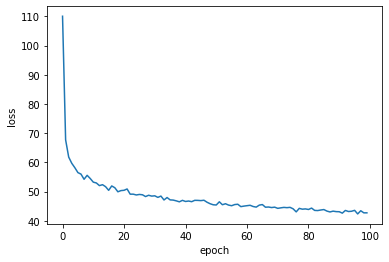

In [17]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [18]:
from sklearn.metrics import classification_report

total_samples,total_labels,log_like=inference.predict(means,sigmas,batch_size=batch_size,num_samples=100,data_loader=val_data)
#y_hat=np.quantile(total_samples,.5,axis=0)
#print(classification_report(np.int32(total_labels),np.int32(y_hat)))

In [23]:
print(np.__version__)

1.19.5


In [26]:
log_like.shape

(100, 157)

In [ ]:
from hamiltonian.utils.psis import *


loo,loos,ks=psisloo(log_like)